In [79]:
import pandas as pd 
import numpy as np
import keras
import math 
import random 

from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler

from lib.Trend import TrendData, extract_trend

In [80]:
'''
Intro 
-----
In order to allow a model to learn as much as possible from a set of data, the important features of the data 
usually must be extracted and arranged in such a way that the model can use them to generalize relationships. 
Often there is a long discovery process, in which the data is interrogated manually in order to intuit what 
features to extract and how to present them. Training the model is usually one of the last steps in a lengthy
process. 

In this example I'm going to focus on price series data, for example a multi-year daily stock price time series, 
and I'm going to demonstrate an example of preprocessing the data to extract a few features, in order to prepare
the data to be used to train an LSTM model. 

This simplified example will consist of the following steps: 

1. Read the data 
2. Extract the daily range (high - low) 
3. Remove the trend 
4. Handle outliers 
5. Scale the data 
6. Extract data about the trend, as a new column 
7. Finally, shape the data into the correct shape to be used as input for a tensorflow LSTM model

Prerequisites: 
- python 3
- scikit-learn 
- pandas 
- jupyter notebook (or jupyter lab) 

The data comes from Yahoo Finance historical data, and is availbale at 

The data comes with the following columns: 
- Open
- High
- Low
- Close 
- Adjusted Close 
- Volume 

At the end of the example, the data will have been transformed, with 3 scaled and normalized columns: 
- Range
- Change
- Trend 

... and will be in the 3-dimensional array shape that a tensorflow LSTM model expects, split into 
training, evaluation, and testing sets. 
'''

'\nIntro \n-----\n- what we will do \n    - preprocess price series data to feed into lstm\n        - extract daily range \n        - remove the trend \n        - remove outliers \n        - scaling the data \n        ? reintroduce the trend \n        - shape the data for lstm \n- why \n\n\nExtract Range \n-------------\n\n\nExtract Trend \n-------------\n\n\nRemove Outliers\n---------------\n\n\nScale the Data\n---------------\n\n\nShape the Data\n---------------\n\n'

In [82]:
'''
The data is read from a file downloaded from the free historical stock data at Yahoo Finance; the columns 
are OHLC, plus Adjusted Close and Volume. Feel free to use any Yahoo historical stock price data, but the 
exact data file that I used is here: 

'''
df = pd.read_csv("data/prices-d.csv", index_col=0)
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-06-29,1.266667,1.666667,1.169333,1.592667,1.592667,281494500
2010-06-30,1.719333,2.028000,1.553333,1.588667,1.588667,257806500
2010-07-01,1.666667,1.728000,1.351333,1.464000,1.464000,123282000
2010-07-02,1.533333,1.540000,1.247333,1.280000,1.280000,77097000
2010-07-06,1.333333,1.333333,1.055333,1.074000,1.074000,103003500


In [85]:
'''
The only column that we won't be touching at all is Volume, so I'll just remove that straightaway. 
Also we don't need 'Close', as we'll use 'Adj Close' instead, as it's better for most purposes.
The other columns will be used to extract useful features, and then afterwards those source columns may be 
discarded from the DataFrame. 
'''
df.pop("Volume")
df.pop("Close")
df.head()

KeyError: 'Volume'

In [84]:
# I. RANGE

In [86]:
'''
I.A: Capture the Range 

The absolute values of the Open, High, and Low won't be useful to us. The daily range as a percentage of 
something (the Open, or previous day's Close for example) could be useful though, so we should extract 
what's useful, and get rid of what's not. 
'''
df["Range"] = (df["High"] - df["Low"]) / df["Open"]
df.head()

,Open,High,Low,Adj Close,Range
Date,,,,,
2010-06-29,1.266667,1.666667,1.169333,1.592667,0.392632
2010-06-30,1.719333,2.028000,1.553333,1.588667,0.276076
2010-07-01,1.666667,1.728000,1.351333,1.464000,0.226000
2010-07-02,1.533333,1.540000,1.247333,1.280000,0.190870
2010-07-06,1.333333,1.333333,1.055333,1.074000,0.208500


In [88]:
'''
I.A.1: Alternate Way

The single line of code above that extracts the daily range is possible thanks to the non-native Python 
library pandas. In case you aren't 
accustomed to using pandas (and just to demonstrate what that line actually does) 
it would be as if I had looped through the data and done this: 
'''
df['Range'] = 0 #add new column 
for i in range(len(df)): 
    df['Range'][i] = (df["High"][i] - df["Low"][i]) / df["Open"][i]
df.head()

/tmp/ipykernel_4562/938355817.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Range'][i] = (df["High"][i] - df["Low"][i]) / df["Open"][i]


,Open,High,Low,Adj Close,Range
Date,,,,,
2010-06-29,1.266667,1.666667,1.169333,1.592667,0.392632
2010-06-30,1.719333,2.028000,1.553333,1.588667,0.276076
2010-07-01,1.666667,1.728000,1.351333,1.464000,0.226000
2010-07-02,1.533333,1.540000,1.247333,1.280000,0.190870
2010-07-06,1.333333,1.333333,1.055333,1.074000,0.208500


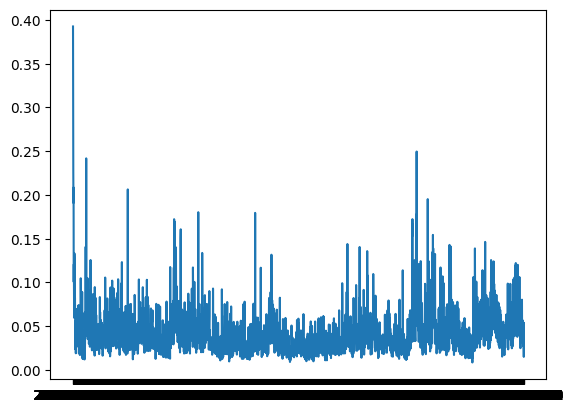

In [90]:
'''
I.B: Plotting the Data

Just to show what the Range column looks like, I will plot it. 
'''
plt.plot(df['Range'])

TODO: verify that there is no trend 
'''
Just a few comments here; you can visually see a few things: 
- there is no discernable strong trend 
- the distribution is noticeably skewed right, with extreme positive outliers 
- the range of the data is not neatly between 0 and 1

The lack of trend is a good thing, we want that to feed into the model. The right-skew and the scale, we will 
fix in later steps. 
'''

<AxesSubplot:ylabel='Density'>

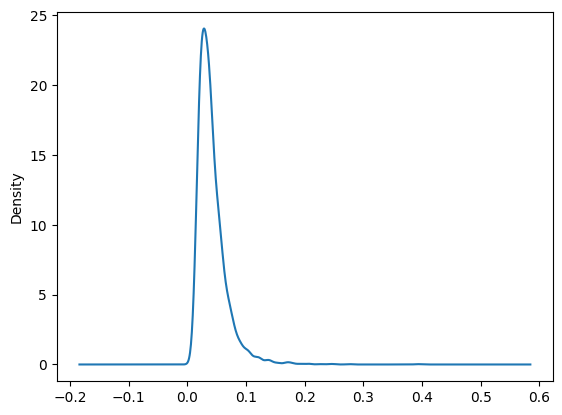

In [91]:
'''
I.C: Plot Distribution

Here I've plotted the distribution to better show the skewness of the data, though you can see it plainly 
enough in the previous plot. Removing outliers should make the data more balanced, so I will do that in a later 
step. 
'''
df['Range'].plot(kind='kde')

In [92]:
'''
I.D: Remove Extra Columns

Now that we've extracted the daily range from the Open, High, and Low columns, we don't need those anymore, 
so I'll just remove them. The information that we needed is now in the Range column. 
'''
# remove extra columns 
df.pop("Open")
df.pop("High")
df.pop("Low")
df.head()

,Adj Close,Range
Date,,
2010-06-29,1.592667,0.392632
2010-06-30,1.588667,0.276076
2010-07-01,1.464000,0.226000
2010-07-02,1.280000,0.190870
2010-07-06,1.074000,0.208500


In [ ]:
# II. Detrending Price (Capture Change)

In [93]:
'''
II.A: Absolute Change 

A data series may have trend, and it may have seasonality. Multi-year stock price data is less likely to show 
seasonality, but very likely to show a strong persistent trend. The problem with trended data (especially 
financial asset data which tends to grow exponentially) is that it smashes early data into oblivion, making 
it nearly invisible to the model trying to generalize something from it. This is why absolute price is 
almost never fed into a model without being heavily processed.

Now for the closing price ('Adj Close' column), again no one cares about the absolute price from day to day, 
what one cares about is the change in price from day to day. Pandas lets us acheive that with the following 
single line: 
'''
df['Abs Change'] = df["Adj Close"].diff()
df.head()

,Adj Close,Range,Abs Change
Date,,,
2010-06-29,1.592667,0.392632,NaN
2010-06-30,1.588667,0.276076,-0.004000
2010-07-01,1.464000,0.226000,-0.124667
2010-07-02,1.280000,0.190870,-0.184000
2010-07-06,1.074000,0.208500,-0.206000


<AxesSubplot:xlabel='Date'>

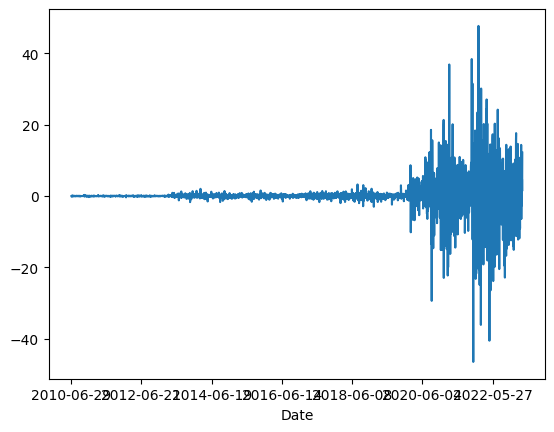

In [95]:
'''
II.A.1: Problem with Absolute Change

But the main problem is evident when we plot this over time. We can see that as the price rose over the years, the 
average daily change also increased, naturally. This is not ideal data to feed into a model, because 
(as you can see) earlier values will be de-emphasized to the point of nearly being ignored, whereas later 
data points will be overemphasized in relation. Since we would like the model to be able to glean meaningful 
data from the entire dataset, this is less than ideal. The plot below shows data that is likely to be 
difficult for a model to extract generalizations from. 
'''
df['Abs Change'].plot()

<AxesSubplot:xlabel='Date'>

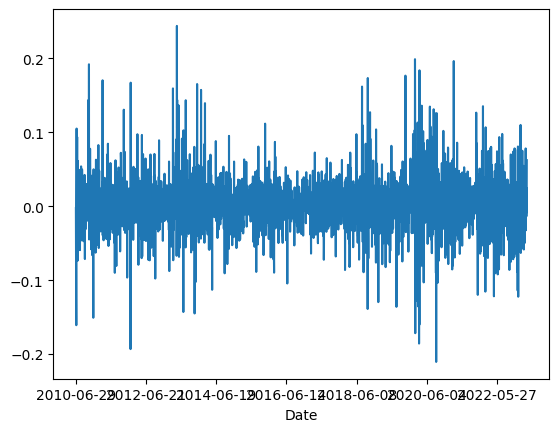

In [96]:
'''
II.B: Percentage Change

Instead, the percentage change is what we want. It's less likely to be skewed or trended, and we can see this visually
by plotting. 
'''
#first remove Abs Change, as we don't need it 
df.pop("Abs Change")

df['Change'] = df["Adj Close"].pct_change()
df['Change'].plot()

In [97]:
'''
II.B.1: NaN in first row 

Note that the very first value for the Pct Change column is a NaN. The reason is that to get this column, each 
value in the source column was compared to its previous timestep, and the first record has no previous to which 
to compare. 
'''
df.head()

,Adj Close,Range,Change
Date,,,
2010-06-29,1.592667,0.392632,NaN
2010-06-30,1.588667,0.276076,-0.002512
2010-07-01,1.464000,0.226000,-0.078473
2010-07-02,1.280000,0.190870,-0.125683
2010-07-06,1.074000,0.208500,-0.160937


In [99]:
'''
II.B.1.a: Remove the NaN

The NaN can be removed reasonably by either basing the first change off of the Open 
(instead of the previous step's Close), or just by simply removing the first row. I'll just remove the first row. 
'''
print('len before:', len(df))
df = df. tail(-1) 
print('len after:', len(df))
df.head()

len before: 3211
len after: 3210


,Adj Close,Range,Change
Date,,,
2010-07-01,1.464000,0.226000,-0.078473
2010-07-02,1.280000,0.190870,-0.125683
2010-07-06,1.074000,0.208500,-0.160937
2010-07-07,1.053333,0.100610,-0.019243
2010-07-08,1.164000,0.120818,0.105064


In [ ]:
# III. Outliers

In [ ]:
'''
The model is best able to extract generalizations from the data if most of the data falls within a normal 
range. Outliers tend to skew the data such that some values (which may be important) will be almost ignored, 
whereas others will be overemphasized. 

Just to clarify I'm not talking here about outliers that may reflect mistakes in the data collection process 
necessarily (bad data samples can often just be discarded), but simply events of unusual magnitude. For 
example, price data that contains a swan event such as a major flash 
crash that is many times larger than the normal daily move may de-emphasize the magnitude of all of the others 
days' data. This can cause a model trained on data that contains the swan event to come up with very different results 
compared to the same model trained on data that did not contain the event. That's not ideal, because it 
indicates that something is interfering with the model's ability to generalize from the available data.
'''


In [ ]:
# III.A: Outliers in Change Column

<AxesSubplot:xlabel='Date'>

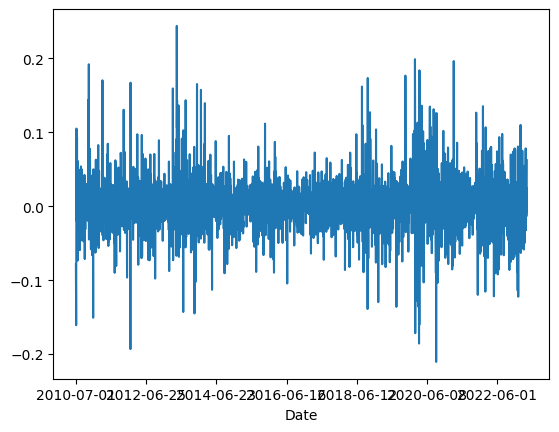

In [100]:
'''
III.A.1: Plot Change Before Handling Outliers

Take another peek at the Change column before handling outliers. Note that just by visual inspection, it's 
clear that most of the data falls into a very small percentage of the full range of values. That should be 
corrected so that at least more than 50% of the data falls within more than 50% of the range (just ballpark 
figures here, there is no real rule of thumb. It would depend on the goals of the data, and your idea of 
what the ideal 'balance' of data is for your situation; but we can see that the data here is clearly not 
well balanced). 
'''
df['Change'].plot()

In [101]:
'''
III.A.2: Function to Squash Outliers

I don't want to remove the rows that contain outliers, because that would be removing real data that we want 
to give to the model. I don't 
want to zero the values either as that would skew the data in a different direction. Instead I would like to 
'squash' the values to within a reasonable range, where outliers >=n will be treated the same as values 
that are equal to n.
'''
def squash_col_outliers(
    df: pd.DataFrame, 
    col_name: str, 
    min_quantile: float =0.01, 
    max_quantile:float =0.99
): 
    q_lo = df[col_name].quantile(min_quantile)
    q_hi  = df[col_name].quantile(max_quantile)
    
    df.loc[df[col_name] >= q_hi, col_name] = q_hi
    df.loc[df[col_name] <= q_lo, col_name] = q_lo
    return df

'''
Min and Max before squashing:
'''
print('MIN:', df['Change'].min())
print('MAX:', df['Change'].max())

MIN: -0.2106282385165198
MAX: 0.24395072987549127


In [102]:
'''
III.A.3: Squash Outliers in Change
'''
df = squash_col_outliers(df, 'Change')

'''
Min and Max after squashing:
'''
print(df['Change'].max())
print(df['Change'].min())

0.10999140535159575
-0.09005347541987191


<AxesSubplot:xlabel='Date'>

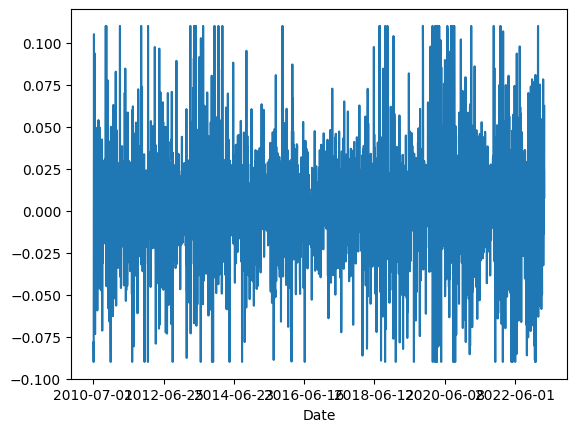

In [104]:
'''
III.A.4: Plot Change After Handling Outliers

Now we can visually see in the plot of Change that there's a more balanced distribution of values, that will be 
more healthy for the model to digest. Again, there is no formula for the perfect balance, and this is part 
of a discovery process in which we'd like to get enough information to intuit a good enough rule, or what is 
closer to an ideal. 
'''
df['Change'].plot()

In [ ]:
# III.B Outliers in Range Column

<AxesSubplot:xlabel='Date'>

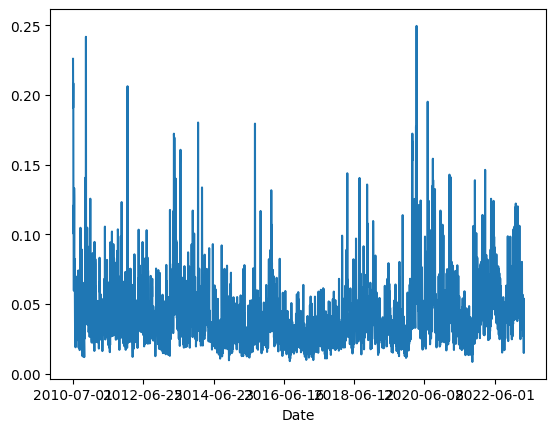

In [107]:
'''
III.B.1: Plot Range Before Handling Outliers

The shape of the Range data is a bit different, so I'm going to do basically the same thing, but I'm going 
to pass different values for the upper and lower limits, so that the left of the distribution will be less 
affected by squashing, and the right of the distribution will be more affected (which is where it's needed). 
I can do that by just passing lower values (lower than the default) for both min_quantile and max_quantile. 
That will cause the function to squash more on the top and less (or not at all, in this case) on the bottom. 
'''
df['Range'].plot()

<AxesSubplot:xlabel='Date'>

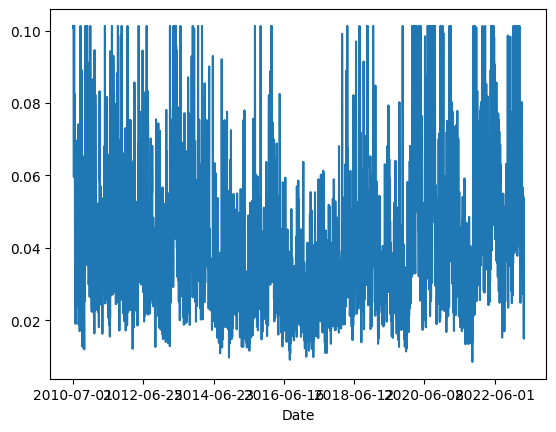

In [108]:
'''
III.B.2: Squash Outliers in Range
'''
df = squash_col_outliers(df, 'Range', min_quantile=0.0, max_quantile=0.97)

'''
And now, we likewise see a more favorable distribution of values. 
'''
df['Range'].plot()

In [109]:
df.head()

,Adj Close,Range,Change
Date,,,
2010-07-01,1.464000,0.101305,-0.078473
2010-07-02,1.280000,0.101305,-0.090053
2010-07-06,1.074000,0.101305,-0.090053
2010-07-07,1.053333,0.100610,-0.019243
2010-07-08,1.164000,0.101305,0.105064


In [ ]:
# IV: Scaling the Data

In [ ]:
'''
Normalization or scaling between 0 and 1 is a convention in data science. 
'''
TODO: explain why 

In [54]:
'''
IV.A The Scaling Function 

This function uses MinMaxScaler from scikitlearn package to fit the values of a given column between 0 and 1 
(or any given values) and replaces the original column in the DataFrame with the new data. 
'''

def scale_col_values(
    df: pd.DataFrame, 
    col_name:str, 
    min_value:float=0, 
    max_value:float=1
): 
    values = df[col_name].values.reshape(-1, 1)
    scaler = MinMaxScaler(feature_range=(min_value, max_value))
    scaled_values = scaler.fit_transform(values)
    df[col_name] = scaled_values.transpose()[0]
    return df

In [55]:
'''
Check the min and max of the Change column before scaling. 
'''
print(df['Change'].min())
print(df['Change'].max())

-0.09003942213352203
0.1099840550645799


In [56]:
df = scale_col_values(df, 'Change')

In [57]:
'''
Check that it's been changed by the scaling process. 
'''
print(df['Change'].min())
print(df['Change'].max())

0.0
1.0


In [ ]:
'''
And very importantly, note that the shape of the data has not changed, it's only been rescaled. The plot 
from before looks the same as after, except for the scale of the y axis. 
'''
df['Change'].plot()

In [ ]:
'''
Scaling of Range is exactly the same. 
'''
df = scale_col_values(df, 'Range')

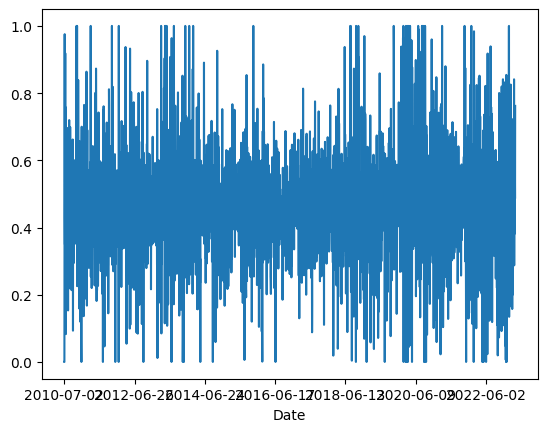

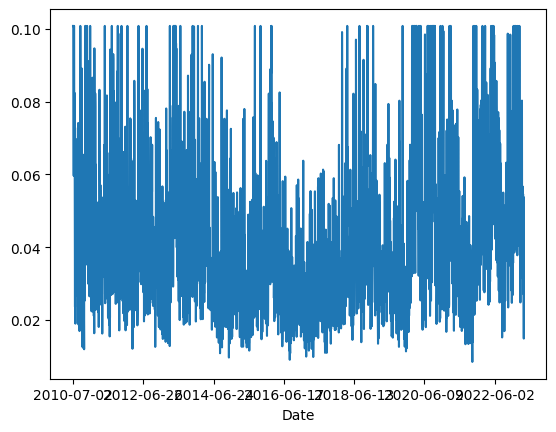

In [59]:
'''
And likewise, the scale has been the only thing changed. 
'''
df['Range'].plot()

In [ ]:
# V. Extracting the Trend

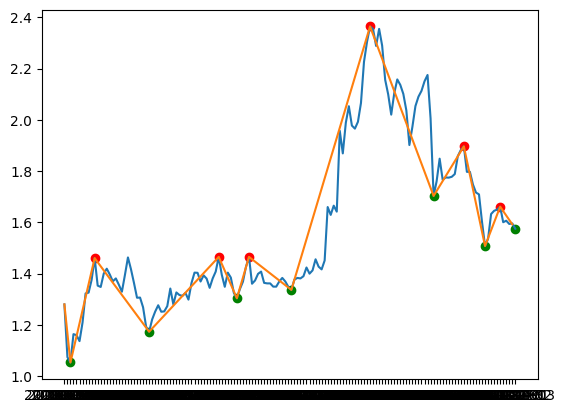

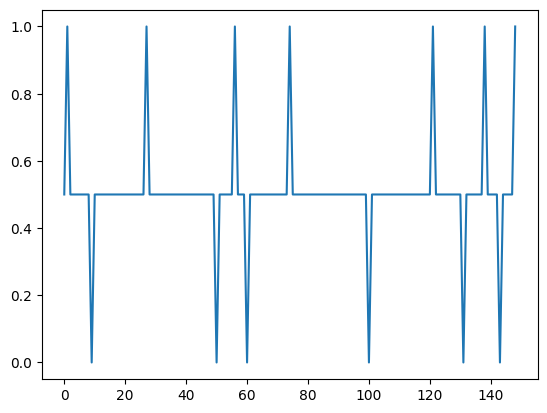

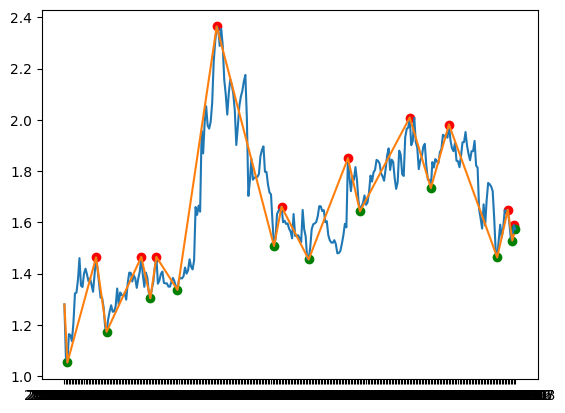

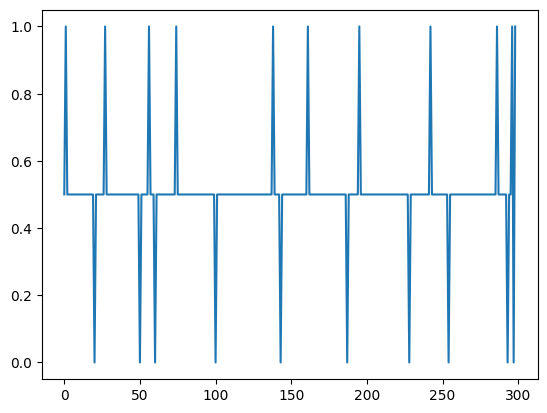

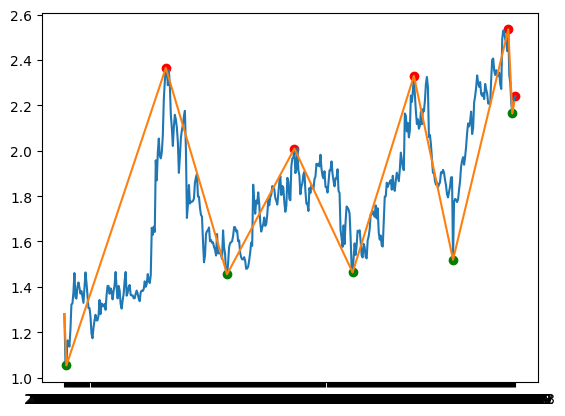

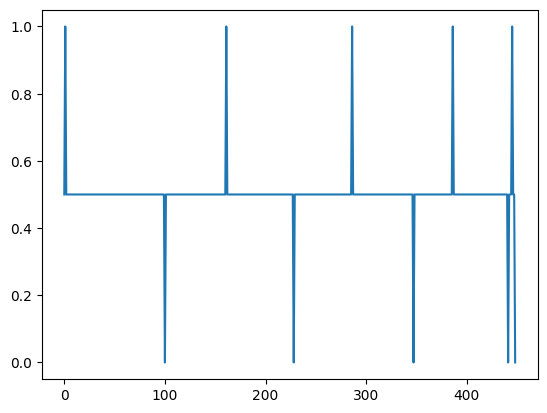

In [62]:
'''
Earlier in the process, we 'removed' the trend from the data by extracting the daily % change. The trend is 
of course still inherent in the % daily change, but it's no longer obvious. However, the trend can be an important 
feature of the data, and for some purposes one may want to extract it as well.  

There are many ways to extract the trend from a time series. One might use arithmetic decomposition, 
or one might be inclined to use a simple MA or EMA, 
but the problem (may be a problem, depending on what you're doing) is that moving averages tend to lag. 
To accurately capture the exact high and low points based on a certain given granularity, I created a 
function to discern non-seasonal (or quasi-seasonal) highs and lows, and draw trendlines between them. 
For this example, I'm going to create then, then extract from it a range of values where 
0: means the trend turns downwards at this point (it's a high point) 
1: means the trend turns upwards at this point (it's a low point)
0.5: means that the current trend continues 

This technique may not be good for de-noisifying a series, but it's good for extracting the pivot points. 
Below is a demonstration of it, with the trendlines overlaid on the original price series, over a few small 
segments of the series (the small segments are more convenient to view). 

Note that passing a smaller value for the period parameter will capture more of the price spikes, and passing
a larger value will tend to capture fewer of them. 
'''
step_size = 150
range_size = 10

for i in range(3): 
    # extract trend from a subset of the price series 
    series = df['Adj Close'][:i*step_size+step_size]
    trend = extract_trend(series, range_size)
    
    # scatterplot: highs are red, lows are green 
    highs_x, highs_y = trend.as_scatterplot('hi')
    lows_x, lows_y = trend.as_scatterplot('lo')

    plt.scatter(highs_x, highs_y, color='red')
    plt.scatter(lows_x, lows_y, color='green')
    plt.plot(series)
    
    # overlay trend lines 
    plt.plot(trend.as_price_series(series[0]))
    plt.show()
    
    # show boolean 
    plt.plot(trend.as_boolean(series[0]))
    plt.show()
    range_size *= 2

In [ ]:
'''
Then this data will be added as a new column to the DataFrame, called 'Trend'. Note that the data is already 
normalized between 0 and 1, so it doesn't require scaling. And there's no need to handle outliers, because 
there are none. 
'''
trend = extract_trend(df['Adj Close'], 100)
df['Trend'] = trend.as_boolean(df['Adj Close'][0])
print(len(trend.as_boolean(df['Adj Close'][0])))
df.head()

In [63]:
# VI: Shaping the Input for LSTM

In [64]:
# extract y column (col to be predicted)
def extract_y(df, colname, ntimesteps): 
    #TODO: don't need to shift here 
    shifted = df.shift(1)
    shifted = shifted.tail(-1) 
    shifted = shifted.tail(-ntimesteps)
    return shifted[colname].values

In [65]:
# extract X 
def extract_X(df, ntimesteps): 
    features = len(df.columns)
    X = list()
    
    #offset for timesteps
    offsets = list()
    for i in range (ntimesteps, 0, -1): 
        offsets.append(df.shift(i))
        
    #combine timestep columns into rows 
    combined = pd.concat(offsets, axis=1)
    combined = combined.tail(-ntimesteps) 
    combined.drop(combined.tail(1).index, inplace=True)
    
    #reshape each row (timesteps, features)
    for i in range(len(combined)): 
        row = combined.iloc[i].to_numpy()
        xrow = list()
        for n in range(ntimesteps): 
            xrow.append(row[n*features:(n*features)+features])
        X.append(xrow)
    
    #return as numpy array
    return np.array(X)

In [66]:
# EXTRACT X and y
timesteps = 10
X = extract_X(df, timesteps)
y = extract_y(df, 'Change', timesteps)

print(X.shape)
print(y.shape)

(3198, 10, 3)
(3198,)


In [69]:
class DataSet:
    def __init__(self, X, y): 
        if X.ndim != 3: 
            raise Exception("Expected a 3-dimensional array for X")
        if y.ndim != 1: 
            raise Exception("Expected a 1-dimensional array for y")
        if len(X) != len(y): 
            raise Exception("Length of X and y must be the same")
        
        self.X = X
        self.y = y
        
    def split(self, pct): 
        count = int(self.size * pct)
        new_dataset = DataSet(self.X[:count], self.y[:count])
        self.X = self.X[:-count]
        self.y = self.y[:-count]
        return new_dataset
        
    @property
    def size(self): 
        return len(self.X)

In [70]:
# SPLIT TO TEST & TRAIN
train = DataSet(X, y)
val = train.split(0.3)
test = val.split(0.3)

In [73]:
print(f'train set has {train.size} samples')
print(f'eval set has {val.size} samples')
print(f'test set has {test.size} samples')

train set has 2239 samples
eval set has 672 samples
test set has 287 samples


In [75]:
print('train X shape:', train.X.shape)
print('eval X shape', val.X.shape)
print('test X shape:', test.X.shape)

train X shape: (2239, 10, 3)
eval X shape (672, 10, 3)
test X shape: (287, 10, 3)
